In [1]:
from pylab import *

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import pymorphy2
from os import path
from os.path import join
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import re
from matplotlib import pylab as plt
from sklearn.preprocessing import normalize
from sklearn.model_selection import cross_val_predict
from sklearn.svm import SVC
import csv
import numpy as np

# Загрузка, фильтрация датасета, подготовка train/test

In [59]:
# загрузка из файла размеченныз диалогов
dataset_dir = './data/'
dataset_names = os.listdir(dataset_dir)
print('Avaliable datasets: {}'.format(dataset_names))

files_names = os.listdir(join(dataset_dir, dataset_names[0]))
print('Avaliable files in dataset {0}: \n{1}'.format(dataset_names[0], dataset_names))

vkus_dataset = pd.read_excel(files_names[0])
# чистим TEXT от мусора ([], ...)
sber_dataset["TEXT"] = [x[0].strip() if isinstance(x, list) else '' for x in sber_dataset["TEXT"].str.split("[")]


In [94]:
# фильтрация неклассифицированных строк + пустых TEXT
sber_filtered_ds = sber_dataset.loc[(sber_dataset['MQ'].notnull()) & (sber_dataset['TEXT'] != ''), ['TEXT', 'MQ']]
# trim  пробелов
sber_filtered_ds["MQ"] = [x.strip() for x in sber_filtered_ds["MQ"]]

In [95]:
# минимальное количество элементов для классов
min_cl_count = 2
# статистика по классам - количество элементов 
sber_grouped_ds = sber_filtered_ds[['MQ', 'TEXT']].groupby(['MQ'])['TEXT'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)
# хвост в Other засовываем
sber_reclass_ds = sber_filtered_ds
sber_reclass_ds.loc[sber_reclass_ds['MQ'].isin(sber_grouped_ds[sber_grouped_ds['count'] < min_cl_count]['MQ']),
                    "MQ"] = 'Other'

In [96]:
# готовим XX
X = np.array(sber_reclass_ds["TEXT"].reset_index(drop=True))

In [210]:
# готовим yy
## список имен классов
y_str = sber_reclass_ds["MQ"].reset_index(drop=True)
## MQ нумеруем по уникальным номерам вопросов
y_unique = np.unique(y_str).tolist()
y = np.array([y_unique.index(y_str_i) for y_str_i in y_str])

In [98]:
# разбиваем датасет на train/test с сохранением соотношений
skf = StratifiedShuffleSplit(n_splits=2, test_size= 1/5, random_state=0)
#StratifiedKFold(n_splits=2)
skf.get_n_splits(X, y)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [89]:
# выгрузка traint и test
pd.concat([pd.DataFrame(X_test), pd.DataFrame(y_test)], axis=1, ignore_index=True). \
    to_csv(path.join(dataset_dir, 'test_ds.xlsx'))
pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1, ignore_index=True). \
    to_csv(path.join(dataset_dir, 'train_ds.xlsx'))

# Классификация

In [8]:
morph = pymorphy2.MorphAnalyzer()


def tokenize(sen):
    sent_toks = sent_tokenize(sen)
    word_toks = [word_tokenize(el) for el in sent_toks]
    tokens = [val for sublist in word_toks for val in sublist]
    tokens = [el for el in tokens if el != '']
    tokens = [el.lower() for el  in tokens]
    tokens = [morph.parse(el)[0].normal_form for el in tokens]
    return tokens

In [9]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon

## готовим tfidf

In [38]:
tfidf = TfidfVectorizer(tokenizer=tokenize, ngram_range=(1, 2))
# тренируем Vectorizer на всех строках из файла кроме test-реплик
#tfidf.fit(sber_dataset[sber_dataset['TEXT'].isin(X_test) == False]['TEXT'])

In [99]:
# эмбедим train и test предложения
x_train_ebm = tfidf.fit_transform(X_train)
x_test_emb = tfidf.transform(X_test)

In [132]:
#print(x_train_ebm)
len(tfidf.vocabulary)

7394

## SGDClassifier

In [257]:
# x_train_ebm / y_train
clf = SGDClassifier(alpha=0.0001, loss='hinge', penalty='l2', n_iter=80, n_jobs=-1)
# clf = OneVsRestClassifier(est)

clf.fit(x_train_ebm, y_train)
y_pred = clf.predict(x_test_emb)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_micro = f1_score(y_test, y_pred, average='micro')
f1 = [f1_macro, f1_weighted, f1_micro]

print(f1)


[0.27294772066024814, 0.57440908397007695, 0.59599477579451454]


## ROC анализ

In [284]:
y_train_ = label_binarize(y_train, classes=np.unique(y))
y_test_ = label_binarize(y_test, classes=np.unique(y))

n_classes = len(np.unique(y))
y_score_ = clf.decision_function(x_test_emb)

from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
thresholds = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], thresholds[i] = roc_curve(y_test_[:, i], y_score_[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [290]:
import numpy as np


def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]


array = np.random.random(10)
print(array)
# [ 0.21069679  0.61290182  0.63425412  0.84635244  0.91599191  0.00213826
#   0.17104965  0.56874386  0.57319379  0.28719469]

value = 0.5

print(find_nearest(array, value))
# 0.568743859261

array([  0.00000000e+00,   4.35350457e-04,   4.35540070e-04, ...,
         9.99564460e-01,   9.99564650e-01,   1.00000000e+00])

In [291]:
thresholds

{0: array([ 0.29559426, -0.70440574, -0.73751694, -0.76425914, -0.91233735,
        -0.91840649, -0.95229293, -0.95523853, -1.04571474, -1.04576909,
        -1.05033436, -1.05064812, -1.05600255, -1.05618169, -1.07973098,
        -1.07974524, -1.08809485, -1.08817707, -1.08893385, -1.08900944,
        -1.104875  , -1.1048845 , -1.11433734, -1.11441912, -1.11980806,
        -1.11985903, -1.12953041, -1.12965479, -1.13807155, -1.13828038,
        -1.16067171, -1.16092362, -1.16584258, -1.16601656, -1.16771754,
        -1.16783704, -1.19069606, -1.19076781, -1.20102846, -1.20103958,
        -1.21860976, -1.2194309 , -1.21973622, -1.21981688, -1.2554172 ,
        -1.25557442, -1.25672251, -1.25690855, -1.27078615, -1.27078655,
        -1.27583592, -1.27586949, -1.27916348, -1.27942791, -1.28173963,
        -1.2820083 , -1.28662963, -1.28685403, -1.28956441, -1.28973553,
        -1.3124169 , -1.31295736, -1.32005393, -1.32039311, -1.32200129,
        -1.32266842, -1.32440651, -1.32441922, -

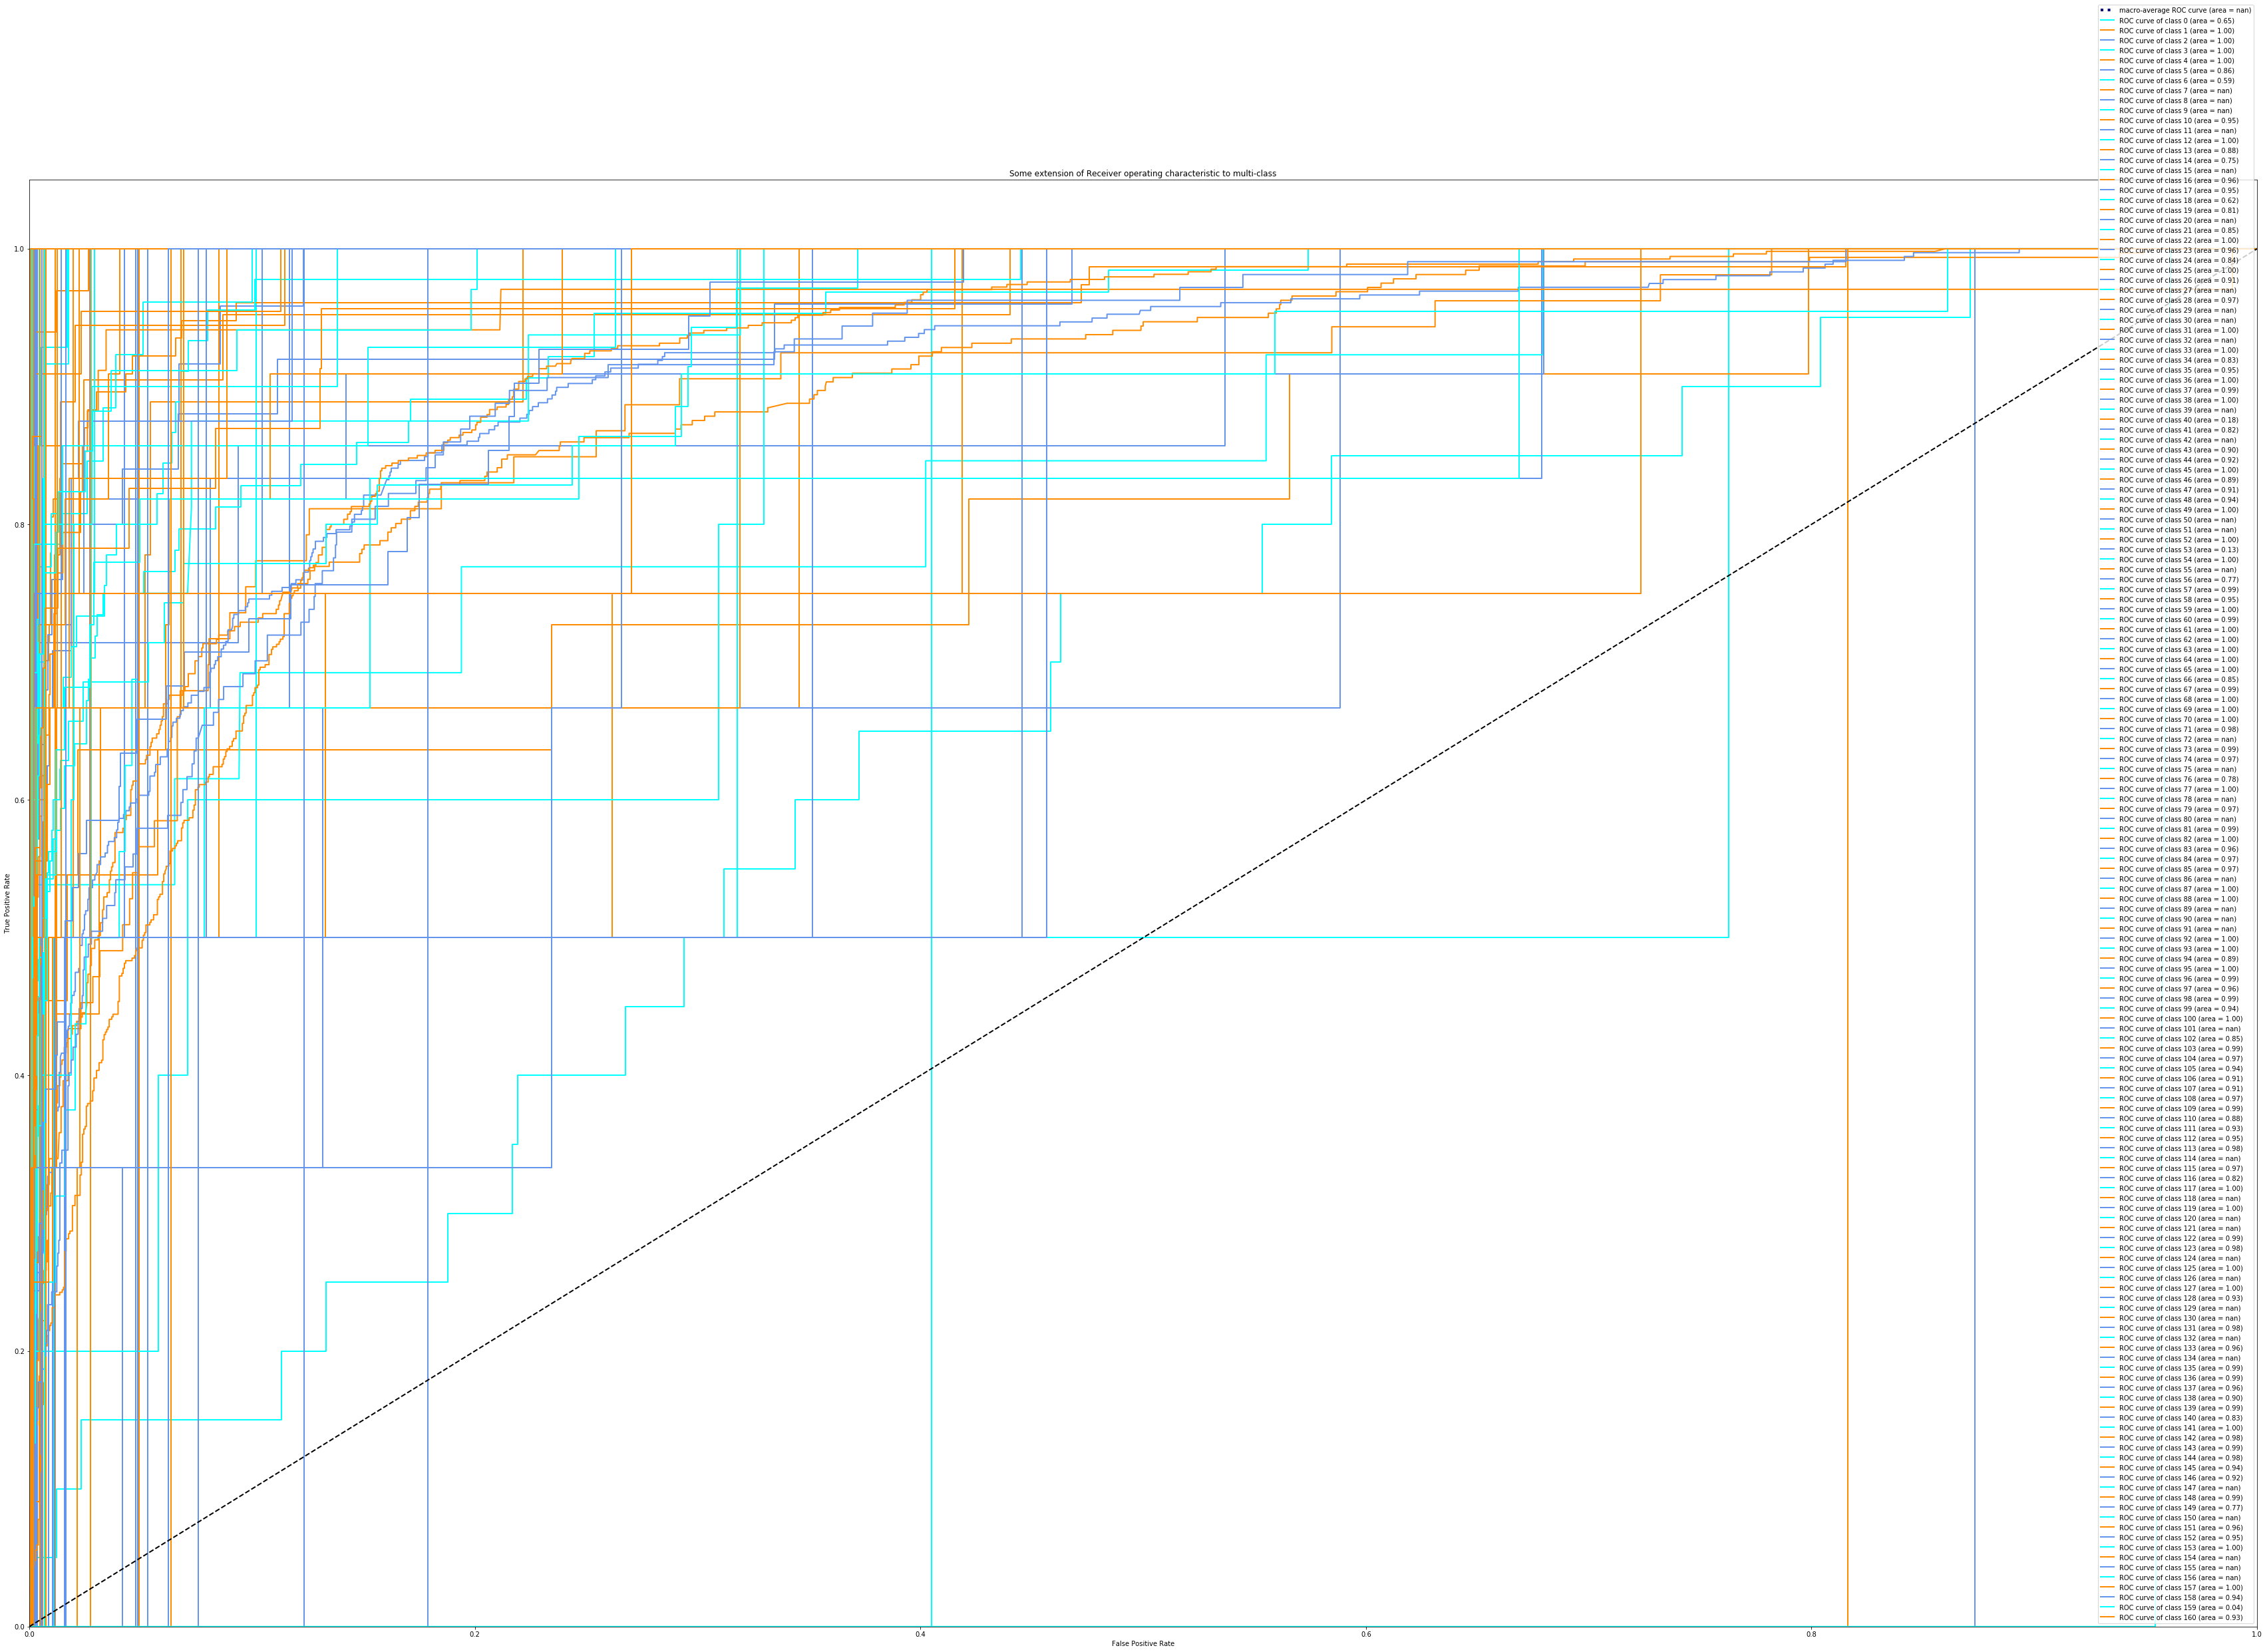

In [286]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.gcf().set_size_inches( (plt.gcf().get_size_inches()[0]*10, plt.gcf().get_size_inches()[1]*10) )

    
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


### SGDClassifier - подбор параметров

In [ ]:
parameters = {
    'loss' : ('hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'),
    'alpha': (0.001, 0.0001, 0.00001, 0.000001),
    'penalty': ('l2', 'elasticnet'),
    'n_iter': (1, 5, 10, 50, 80)
}
random_search = RandomizedSearchCV(clf, param_distributions=parameters, n_jobs=-1, n_iter=360)
res = random_search.fit(x_train_ebm, y_train)

In [ ]:
res.cv_results_
res.best_estimator_

## one vs all LinearSVC

In [242]:
clf = LinearSVC(C=1.2741038237672748)
#clf=sklearn.svm.SVC(kernel='linear',probability=True)
clf_ova = OneVsRestClassifier(clf)
clf_ova.fit(x_train_ebm, y_train)
y_pred = clf_ova.predict(x_test_emb)
#y_pred_proba = clf_ova.predict_proba(x_test_emb)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_micro = f1_score(y_test, y_pred, average='micro')
f1 = [f1_macro, f1_weighted, f1_micro]
print(f1)

[0.21497282577457941, 0.57546138443469241, 0.59686547670875056]


In [ ]:
y_pred_proba

### one vs all - подбор параметров

In [ ]:
parameters = {
    'C': expon(scale=1)
}
random_search = RandomizedSearchCV(clf, param_distributions = parameters,
                                   n_iter=10, n_jobs=-1)
res = random_search.fit(x_train_ebm, y_train)

In [ ]:
res.best_estimator_

## direct LinearSVC

In [187]:
clf = LinearSVC(C=0.8873076204728344, class_weight ='balanced')
warnings.filterwarnings("ignore", category=DeprecationWarning)
scores = cross_validate(clf, x_train_ebm, y_train,
                        scoring=['f1_macro', 'f1_weighted', 'precision_macro', 'precision_weighted'],
                        cv=5)

print("f1_macro - %s, f1_weighted - %s, - %s, - %s"\
      % (scores['test_f1_macro'].mean(),scores['test_f1_weighted'].mean(),
         scores['test_precision_macro'].mean(),scores['test_precision_weighted'].mean()))

#proba = cross_val_predict(logreg, X, y, cv=cv, method='predict_proba')

#y_train_pred = cross_val_predict
#clf.predict(x_train_ebm)

clf.fit(x_train_ebm, y_train)
y_test_pred = clf.predict(x_test_emb)

prec = [precision_score(y_test, y_test_pred, average='macro'),
    precision_score(y_test, y_test_pred, average='weighted'),
    precision_score(y_test, y_test_pred, average='micro')]
recall = [recall_score(y_test, y_test_pred, average='macro'),
    recall_score(y_test, y_test_pred, average='weighted'),
    recall_score(y_test, y_test_pred, average='micro')]
f1 = [f1_score(y_test, y_test_pred, average='macro'),
    f1_score(y_test, y_test_pred, average='weighted'),
    f1_score(y_test, y_test_pred, average='micro')]

print(prec)
print(recall)
print(f1)

f1_macro - 0.272380704946, f1_weighted - 0.533526436728, - 0.241422855697, - 0.609582420331
[0.22434574972741106, 0.59406281527146898, 0.50848933391380058]
[0.32867311338695615, 0.50848933391380058, 0.50848933391380058]
[0.25615967448547627, 0.52655496829331616, 0.50848933391380058]


### direct - подбор параметров

In [50]:
param_dist = {'C': expon(scale=1)}
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=50, n_jobs=-1)
res = random_search.fit(x_train_ebm, y_train)

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/usr/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/usr/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x7ff26a1f85d0, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/raf/dev/ENV/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/raf/dev/ENV/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/raf/de.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7ff26a1f85d0, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/raf/dev/ENV/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/raf/dev/ENV/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/raf/de.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/home/raf/dev/ENV/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/home/raf/dev/ENV/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/home/raf/dev/ENV/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/raf/dev/ENV/lib/python3.6/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/home/raf/dev/ENV/lib/python3.6/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/home/raf/dev/ENV/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/home/raf/dev/ENV/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/home/raf/dev/ENV/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/home/raf/dev/ENV/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/home/raf/dev/ENV/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/home/raf/dev/ENV/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/raf/dev/ENV/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': "param_dist = {\n    'C': expon(scale=1), 'class_w...-1)\nres = random_search.fit(x_train_ebm, y_train)", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 11, 16, 8, 47, 23, 123289, tzinfo=tzutc()), 'msg_id': 'FDE80BE03A3A478CB08C1D0BE6B5D00B', 'msg_type': 'execute_request', 'session': '687396B5DBF947A48DD512747D91F507', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'FDE80BE03A3A478CB08C1D0BE6B5D00B', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'687396B5DBF947A48DD512747D91F507']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': "param_dist = {\n    'C': expon(scale=1), 'class_w...-1)\nres = random_search.fit(x_train_ebm, y_train)", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 11, 16, 8, 47, 23, 123289, tzinfo=tzutc()), 'msg_id': 'FDE80BE03A3A478CB08C1D0BE6B5D00B', 'msg_type': 'execute_request', 'session': '687396B5DBF947A48DD512747D91F507', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'FDE80BE03A3A478CB08C1D0BE6B5D00B', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
/home/raf/dev/ENV/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'687396B5DBF947A48DD512747D91F507'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': "param_dist = {\n    'C': expon(scale=1), 'class_w...-1)\nres = random_search.fit(x_train_ebm, y_train)", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 11, 16, 8, 47, 23, 123289, tzinfo=tzutc()), 'msg_id': 'FDE80BE03A3A478CB08C1D0BE6B5D00B', 'msg_type': 'execute_request', 'session': '687396B5DBF947A48DD512747D91F507', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'FDE80BE03A3A478CB08C1D0BE6B5D00B', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/home/raf/dev/ENV/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code="param_dist = {\n    'C': expon(scale=1), 'class_w...-1)\nres = random_search.fit(x_train_ebm, y_train)", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = "param_dist = {\n    'C': expon(scale=1), 'class_w...-1)\nres = random_search.fit(x_train_ebm, y_train)"
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/home/raf/dev/ENV/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=("param_dist = {\n    'C': expon(scale=1), 'class_w...-1)\nres = random_search.fit(x_train_ebm, y_train)",), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ("param_dist = {\n    'C': expon(scale=1), 'class_w...-1)\nres = random_search.fit(x_train_ebm, y_train)",)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/home/raf/dev/ENV/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="param_dist = {\n    'C': expon(scale=1), 'class_w...-1)\nres = random_search.fit(x_train_ebm, y_train)", store_history=True, silent=False, shell_futures=True)
   2723                 self.displayhook.exec_result = result
   2724 
   2725                 # Execute the user code
   2726                 interactivity = "none" if silent else self.ast_node_interactivity
   2727                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2728                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2729                 
   2730                 self.last_execution_succeeded = not has_raised
   2731                 self.last_execution_result = result
   2732 

...........................................................................
/home/raf/dev/ENV/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>], cell_name='<ipython-input-50-f6b61cd28fa4>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7ff210e02160, executi..._before_exec=None error_in_exec=None result=None>)
   2845 
   2846         try:
   2847             for i, node in enumerate(to_run_exec):
   2848                 mod = ast.Module([node])
   2849                 code = compiler(mod, cell_name, "exec")
-> 2850                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7ff21c6c8270, file "<ipython-input-50-f6b61cd28fa4>", line 6>
        result = <ExecutionResult object at 7ff210e02160, executi..._before_exec=None error_in_exec=None result=None>
   2851                     return True
   2852 
   2853             for i, node in enumerate(to_run_interactive):
   2854                 mod = ast.Interactive([node])

...........................................................................
/home/raf/dev/ENV/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7ff21c6c8270, file "<ipython-input-50-f6b61cd28fa4>", line 6>, result=<ExecutionResult object at 7ff210e02160, executi..._before_exec=None error_in_exec=None result=None>)
   2905         outflag = True  # happens in more places, so it's easier as default
   2906         try:
   2907             try:
   2908                 self.hooks.pre_run_code_hook()
   2909                 #rprint('Running code', repr(code_obj)) # dbg
-> 2910                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7ff21c6c8270, file "<ipython-input-50-f6b61cd28fa4>", line 6>
        self.user_global_ns = {'ElasticNet': <class 'sklearn.linear_model.coordinate_descent.ElasticNet'>, 'In': ['', 'import numpy as np\nfrom sklearn.feature_extracti...ab as plt\nfrom os import path\nimport pandas as pd', '# загрузка из файла размеченныз диалогов\ndataset...\'\' for x in sber_dataset["TEXT"].str.split("[") ]', '# фильтрация неклассифицированных строк + пустых...Q"] = [x.strip() for x in sber_filtered_ds["MQ"]]', '# минимальное количество элементов для классов\nm...ount][\'MQ\']),\n                    "MQ"] = \'Other\'', '# готовим XX\nX = np.array(sber_reclass_ds["TEXT"].reset_index(drop=True))', '# готовим yy\n## список имен классов\ny_str = sber...y([y_unique.index(y_str_i) for y_str_i in y_str])', '# разбиваем датасет на train/test\nfrom sklearn.m...  y_train, y_test = y[train_index], y[test_index]', 'morph = pymorphy2.MorphAnalyzer()\n\ndef tokenize(...].normal_form for el in tokens]\n    return tokens', 'from sklearn.model_selection import RandomizedSearchCV\nfrom scipy.stats import expon', "tfidf = TfidfVectorizer(tokenizer=tokenize, ngra...r_dataset['TEXT'].isin(X_test) == False]['TEXT'])", '# эмбедим train и test предложения\nx_train_ebm =...orm(X_train)\nx_test_emb = tfidf.transform(X_test)', '# x_train_ebm / y_train\nclf = SGDClassifier(alph...f1 = [f1_macro, f1_weighted, f1_micro]\n\nprint(f1)', "phrases_test = ['']\nphrases_weights_test = tfidf...eights_test)\nnp.unique(y_str).tolist()[y_pred[0]]", "param_dist = {\n    'C': expon(scale=1)\n}\nrandom_...-1)\nres = random_search.fit(x_train_ebm, y_train)", "clf = LinearSVC(C=0.8873076204728344)\nclf.fit(x_...ge='micro')]\n\nprint(prec)\nprint(recall)\nprint(f1)", "param_dist = {\n    'C': expon(scale=1)\n}\nrandom_...-1)\nres = random_search.fit(x_train_ebm, y_train)", 'res.cv_results_\nres.best_estimator_', "clf = LinearSVC(C=0.79043209331339581)\nclf.fit(x...ge='micro')]\n\nprint(prec)\nprint(recall)\nprint(f1)", "clf = LinearSVC(C=0.8873076204728344)\nclf.fit(x_...ge='micro')]\n\nprint(prec)\nprint(recall)\nprint(f1)", ...], 'LinearSVC': <class 'sklearn.svm.classes.LinearSVC'>, 'OneVsRestClassifier': <class 'sklearn.multiclass.OneVsRestClassifier'>, 'Out': {10: TfidfVectorizer(analyzer='word', binary=False, d...1b77fd90>, use_idf=True,
        vocabulary=None), 13: 'Other', 17: LinearSVC(C=0.79043209331339581, class_weight=No...', random_state=None,
     tol=0.0001, verbose=0), 20: TfidfVectorizer(analyzer='word', binary=False, d...1b77fd90>, use_idf=True,
        vocabulary=None), 23: array([17, 13,  5, ...,  0, 13, 13]), 43: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 1..., 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69]), 44: array([  0.35272657,   5.70496894,   3.74897959,... 13.12142857,
         1.42624224,   8.74761905])}, 'RandomizedSearchCV': <class 'sklearn.model_selection._search.RandomizedSearchCV'>, 'SGDClassifier': <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'>, 'StratifiedShuffleSplit': <class 'sklearn.model_selection._split.StratifiedShuffleSplit'>, 'TfidfVectorizer': <class 'sklearn.feature_extraction.text.TfidfVectorizer'>, 'X': array([ 'Здравствуйте.12 мая оформил кредит онла...едитный лимит по кредитной карте'], dtype=object), ...}
        self.user_ns = {'ElasticNet': <class 'sklearn.linear_model.coordinate_descent.ElasticNet'>, 'In': ['', 'import numpy as np\nfrom sklearn.feature_extracti...ab as plt\nfrom os import path\nimport pandas as pd', '# загрузка из файла размеченныз диалогов\ndataset...\'\' for x in sber_dataset["TEXT"].str.split("[") ]', '# фильтрация неклассифицированных строк + пустых...Q"] = [x.strip() for x in sber_filtered_ds["MQ"]]', '# минимальное количество элементов для классов\nm...ount][\'MQ\']),\n                    "MQ"] = \'Other\'', '# готовим XX\nX = np.array(sber_reclass_ds["TEXT"].reset_index(drop=True))', '# готовим yy\n## список имен классов\ny_str = sber...y([y_unique.index(y_str_i) for y_str_i in y_str])', '# разбиваем датасет на train/test\nfrom sklearn.m...  y_train, y_test = y[train_index], y[test_index]', 'morph = pymorphy2.MorphAnalyzer()\n\ndef tokenize(...].normal_form for el in tokens]\n    return tokens', 'from sklearn.model_selection import RandomizedSearchCV\nfrom scipy.stats import expon', "tfidf = TfidfVectorizer(tokenizer=tokenize, ngra...r_dataset['TEXT'].isin(X_test) == False]['TEXT'])", '# эмбедим train и test предложения\nx_train_ebm =...orm(X_train)\nx_test_emb = tfidf.transform(X_test)', '# x_train_ebm / y_train\nclf = SGDClassifier(alph...f1 = [f1_macro, f1_weighted, f1_micro]\n\nprint(f1)', "phrases_test = ['']\nphrases_weights_test = tfidf...eights_test)\nnp.unique(y_str).tolist()[y_pred[0]]", "param_dist = {\n    'C': expon(scale=1)\n}\nrandom_...-1)\nres = random_search.fit(x_train_ebm, y_train)", "clf = LinearSVC(C=0.8873076204728344)\nclf.fit(x_...ge='micro')]\n\nprint(prec)\nprint(recall)\nprint(f1)", "param_dist = {\n    'C': expon(scale=1)\n}\nrandom_...-1)\nres = random_search.fit(x_train_ebm, y_train)", 'res.cv_results_\nres.best_estimator_', "clf = LinearSVC(C=0.79043209331339581)\nclf.fit(x...ge='micro')]\n\nprint(prec)\nprint(recall)\nprint(f1)", "clf = LinearSVC(C=0.8873076204728344)\nclf.fit(x_...ge='micro')]\n\nprint(prec)\nprint(recall)\nprint(f1)", ...], 'LinearSVC': <class 'sklearn.svm.classes.LinearSVC'>, 'OneVsRestClassifier': <class 'sklearn.multiclass.OneVsRestClassifier'>, 'Out': {10: TfidfVectorizer(analyzer='word', binary=False, d...1b77fd90>, use_idf=True,
        vocabulary=None), 13: 'Other', 17: LinearSVC(C=0.79043209331339581, class_weight=No...', random_state=None,
     tol=0.0001, verbose=0), 20: TfidfVectorizer(analyzer='word', binary=False, d...1b77fd90>, use_idf=True,
        vocabulary=None), 23: array([17, 13,  5, ...,  0, 13, 13]), 43: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 1..., 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69]), 44: array([  0.35272657,   5.70496894,   3.74897959,... 13.12142857,
         1.42624224,   8.74761905])}, 'RandomizedSearchCV': <class 'sklearn.model_selection._search.RandomizedSearchCV'>, 'SGDClassifier': <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'>, 'StratifiedShuffleSplit': <class 'sklearn.model_selection._split.StratifiedShuffleSplit'>, 'TfidfVectorizer': <class 'sklearn.feature_extraction.text.TfidfVectorizer'>, 'X': array([ 'Здравствуйте.12 мая оформил кредит онла...едитный лимит по кредитной карте'], dtype=object), ...}
   2911             finally:
   2912                 # Reset our crash handler in place
   2913                 sys.excepthook = old_excepthook
   2914         except SystemExit as e:

...........................................................................
/home/raf/dev/<ipython-input-50-f6b61cd28fa4> in <module>()
      1 param_dist = {
      2     'C': expon(scale=1), 'class_weight':'balanced'
      3 }
      4 random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
      5                                    n_iter=50, n_jobs=-1)
----> 6 res = random_search.fit(x_train_ebm, y_train)

...........................................................................
/home/raf/dev/ENV/lib/python3.6/site-packages/sklearn/model_selection/_search.py in fit(self=RandomizedSearchCV(cv=None, error_score='raise',...return_train_score=True, scoring=None, verbose=0), X=<9185x41539 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>, y=array([20, 16, 16, ..., 20, 20, 16]), groups=None, **fit_params={})
    633                                   return_train_score=self.return_train_score,
    634                                   return_n_test_samples=True,
    635                                   return_times=True, return_parameters=False,
    636                                   error_score=self.error_score)
    637           for parameters, (train, test) in product(candidate_params,
--> 638                                                    cv.split(X, y, groups)))
        cv.split = <bound method StratifiedKFold.split of Stratifie...ld(n_splits=3, random_state=None, shuffle=False)>
        X = <9185x41539 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>
        y = array([20, 16, 16, ..., 20, 20, 16])
        groups = None
    639 
    640         # if one choose to see train score, "out" will contain train score info
    641         if self.return_train_score:
    642             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
/home/raf/dev/ENV/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Thu Nov 16 11:47:23 2017
PID: 25565                      Python 3.6.3: /home/raf/dev/ENV/bin/python3
...........................................................................
/home/raf/dev/ENV/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (LinearSVC(C=1.106231388895123, class_weight='b',...', random_state=None,
     tol=0.0001, verbose=0), <9185x41539 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>, array([20, 16, 16, ..., 20, 20, 16]), {'score': <function _passthrough_scorer>}, array([1734, 1866, 1891, ..., 9182, 9183, 9184]), array([   0,    1,    2, ..., 4989, 5262, 6703]), 0, {'C': 1.106231388895123, 'class_weight': 'b'}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': True})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/raf/dev/ENV/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (LinearSVC(C=1.106231388895123, class_weight='b',...', random_state=None,
     tol=0.0001, verbose=0), <9185x41539 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>, array([20, 16, 16, ..., 20, 20, 16]), {'score': <function _passthrough_scorer>}, array([1734, 1866, 1891, ..., 9182, 9183, 9184]), array([   0,    1,    2, ..., 4989, 5262, 6703]), 0, {'C': 1.106231388895123, 'class_weight': 'b'})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': True}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/raf/dev/ENV/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=LinearSVC(C=1.106231388895123, class_weight='b',...', random_state=None,
     tol=0.0001, verbose=0), X=<9185x41539 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>, y=array([20, 16, 16, ..., 20, 20, 16]), scorer={'score': <function _passthrough_scorer>}, train=array([1734, 1866, 1891, ..., 9182, 9183, 9184]), test=array([   0,    1,    2, ..., 4989, 5262, 6703]), verbose=0, parameters={'C': 1.106231388895123, 'class_weight': 'b'}, fit_params={}, return_train_score=True, return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    432 
    433     try:
    434         if y_train is None:
    435             estimator.fit(X_train, **fit_params)
    436         else:
--> 437             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method LinearSVC.fit of LinearSVC(C=1.106..., random_state=None,
     tol=0.0001, verbose=0)>
        X_train = <6099x41539 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>
        y_train = array([61, 12, 12, ..., 20, 20, 16])
        fit_params = {}
    438 
    439     except Exception as e:
    440         # Note fit time as time until error
    441         fit_time = time.time() - start_time

...........................................................................
/home/raf/dev/ENV/lib/python3.6/site-packages/sklearn/svm/classes.py in fit(self=LinearSVC(C=1.106231388895123, class_weight='b',...', random_state=None,
     tol=0.0001, verbose=0), X=<6099x41539 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>, y=array([61, 12, 12, ..., 20, 20, 16]), sample_weight=None)
    230 
    231         self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
    232             X, y, self.C, self.fit_intercept, self.intercept_scaling,
    233             self.class_weight, self.penalty, self.dual, self.verbose,
    234             self.max_iter, self.tol, self.random_state, self.multi_class,
--> 235             self.loss, sample_weight=sample_weight)
        self.loss = 'squared_hinge'
        sample_weight = None
    236 
    237         if self.multi_class == "crammer_singer" and len(self.classes_) == 2:
    238             self.coef_ = (self.coef_[1] - self.coef_[0]).reshape(1, -1)
    239             if self.fit_intercept:

...........................................................................
/home/raf/dev/ENV/lib/python3.6/site-packages/sklearn/svm/base.py in _fit_liblinear(X=<6099x41539 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>, y=array([61, 12, 12, ..., 20, 20, 16]), C=1.106231388895123, fit_intercept=True, intercept_scaling=1, class_weight='b', penalty='l2', dual=True, verbose=0, max_iter=1000, tol=0.0001, random_state=None, multi_class='ovr', loss='squared_hinge', epsilon=0.1, sample_weight=None)
    850         if len(classes_) < 2:
    851             raise ValueError("This solver needs samples of at least 2 classes"
    852                              " in the data, but the data contains only one"
    853                              " class: %r" % classes_[0])
    854 
--> 855         class_weight_ = compute_class_weight(class_weight, classes_, y)
        class_weight_ = undefined
        class_weight = 'b'
        classes_ = array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 1..., 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69])
        y = array([61, 12, 12, ..., 20, 20, 16])
    856     else:
    857         class_weight_ = np.empty(0, dtype=np.float64)
    858         y_ind = y
    859     liblinear.set_verbosity_wrap(verbose)

...........................................................................
/home/raf/dev/ENV/lib/python3.6/site-packages/sklearn/utils/class_weight.py in compute_class_weight(class_weight='b', classes=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 1..., 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69]), y=array([61, 12, 12, ..., 20, 20, 16]))
     57     else:
     58         # user-defined dictionary
     59         weight = np.ones(classes.shape[0], dtype=np.float64, order='C')
     60         if not isinstance(class_weight, dict):
     61             raise ValueError("class_weight must be dict, 'balanced', or None,"
---> 62                              " got: %r" % class_weight)
        class_weight = 'b'
     63         for c in class_weight:
     64             i = np.searchsorted(classes, c)
     65             if i >= len(classes) or classes[i] != c:
     66                 raise ValueError("Class label {} not present.".format(c))

ValueError: class_weight must be dict, 'balanced', or None, got: 'b'
___________________________________________________________________________

In [17]:
res.cv_results_
res.best_estimator_

LinearSVC(C=0.79043209331339581, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=None,
     tol=0.0001, verbose=0)

In [ ]:
import plotly.graph_objs as go
import plotly
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)

data = [go.Histogram(expon(scale=1))]

#plotly.offline.iplot(data)
data

## ElasticNet

In [ ]:
clf = ElasticNet(alpha=0.0002, l1_ratio=0.1)
clf_ova = OneVsRestClassifier(clf, n_jobs=-1)
clf_ova.fit(x_train_ebm, y_train)
y_pred = clf_ova.predict(x_test_emb)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_micro = f1_score(y_test, y_pred, average='micro')
f1 = [f1_macro, f1_weighted, f1_micro]
print(f1)

In [ ]:
words_idx = [el[0] for el in sorted(tfidf.vocabulary_.items(), key=lambda x: x[1])]
# for i in range(len(tfidf.vocabulary_)):
#     words_idx.append(tfidf.vocabulary_[i])

In [ ]:
class_id = 21
print(np.unique(y_str)[class_id])
sorted(zip(words_idx, clf_ova.coef_[class_id]), key=lambda x: np.abs(x[1]), reverse=True)

# Классификация по Avg (tf-idf взвешенные эмбединги слов)

In [53]:
import fasttext
from gensim.models.wrappers import FastText as gs_fasttext

model = fasttext.load_model('/home/raf/dev/leo_classifiers/ft_sber_sg_300.bin')
#model = fasttext.load_model('/home/raf/dev/leo_classifiers/ft_0.8.3_nltk_yalen_sg_300.bin')
#model = gs_fasttext.load_fasttext_format('/home/raf/dev/emb/lenta+wiki+ted+tedx-1.bin')

In [54]:
# множество w2v токенов датасета
tok2emb = {}
# сбор коллекции w2v токенов, возврат Списка токенов
def add_items(sentence_li, model, tok2emb, add=True):
    tokens_li = []
    for sen in sentence_li:
        tokens = tokenize(sen)
        tokens_li.append(tokens)
        for tok in tokens:
            if add:
                if tok2emb.get(tok) is None:
                    tok2emb[tok] = model[tok]
    return tokens_li

# предсбор множества токенов
add_items(X, model, tok2emb);

# проиндексированный словарь
ind = np.arange(len(tok2emb))
vocab = {el[0]: el[1] for el in zip(tok2emb.keys(), ind)}

In [55]:
# нормирование вектора весов по выражениям 
def q_weights(u_toks, weights, vocab):
    q_weights = []
    for i in range(len(u_toks)):
        w = []
        for t in u_toks[i]:
            if vocab.get(t) is not None:
                w.append(weights[i, vocab[t]])
        w = np.array(w)

        w = w / np.sum(w)
        q_weights.append(w)
    return q_weights


# эмбединги фраз как Avg(взвешенные эмбединги слов)
def u_weighted_emb(sen_li, model, tok2emb, tok_weights):
    vecs = []
    for i in range(len(sen_li)):
        try:
            vec = np.average(np.array([tok2emb.get(tok) for tok in sen_li[i] if tok2emb.get(tok) is not None]),
                             axis=0, weights=tok_weights[i])
            vecs.append(vec)
        except:
            print(i, sen_li[i])
            raise

    return vecs


# объявляем векторизатор
tfidf = TfidfVectorizer(tokenizer=tokenize, vocabulary=vocab)

In [56]:
# train-токены
X_train_toks = add_items(X_train, model, tok2emb)
# tf-idf для train
X_train_tfidf = tfidf.fit_transform(X_train)
# взвешенный tf-idf для train
X_train_tok_weights = q_weights(X_train_toks, X_train_tfidf, vocab)
# эмбединги для для train
X_train_weighted_emb = u_weighted_emb(X_train_toks, model, tok2emb, X_train_tok_weights)
X_train_weighted_emb = np.array(X_train_weighted_emb)

# аналогично для test
X_test_toks = add_items(X_test, model, tok2emb, add=False)
X_test_tfidf = tfidf.transform(X_test)
X_test_tok_weights = q_weights(X_test_toks, X_test_tfidf, vocab)
X_test_weighted_emb = u_weighted_emb(X_test_toks, model, tok2emb, X_test_tok_weights)
X_test_weighted_emb = np.array(X_test_weighted_emb)

In [58]:
clf = LinearSVC(class_weight ='balanced')
clf_ova = OneVsRestClassifier(clf)
clf_ova.fit(X_train_weighted_emb, y_train)
y_pred = clf_ova.predict(X_test_weighted_emb)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_micro = f1_score(y_test, y_pred, average='micro')
f1 = [f1_macro, f1_weighted, f1_micro]
print(f1)

[0.39909474688293622, 0.56081731676821844, 0.55463648236830654]


/home/raf/dev/ENV/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
